# Sorting Toxic Comments With TFIDF

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
73018,c35c82af022cdbb7,"""Thomas.Hedden|Thomas.Hedden]] (talk • contrib...",0,0,0,0,0,0
9516,1938e16dca583fc0,Why should I do that? Nobody says its a must h...,0,0,0,0,0,0
5342,0e37a1d465496716,"""************************ HENRIETTA VAN LAER s...",0,0,0,0,0,0


### there're many versions of toxicity, but we're going to use binary classification

In [3]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train['y'] = train[class_names].max(axis=1).values
train['y'].value_counts()

0    143346
1     16225
Name: y, dtype: int64

### train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('y', 1), 
                                                    train['y'], random_state=0)

### let's take a look on distribution of classes in y_train and y_test

In [5]:
y_train.value_counts(normalize=True)

0    0.897458
1    0.102542
Name: y, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.90091
1    0.09909
Name: y, dtype: float64

### let's assemble a pipeline and fit the model

In [7]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),  # important hyperparameter
                     ('clf', LogisticRegression(C=0.1, solver='sag'))])

# cross-validation
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

# fitting the classifier
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.9552645186298075


### let's draw ROC-curve

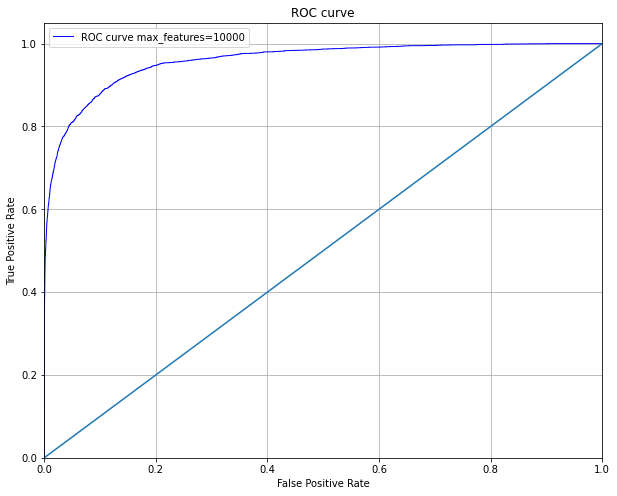

In [8]:
# the code (including the pipeline) has to be launched twice - max_features=100, max_features=10000

plt.figure(figsize=(10, 8))
# fpr_mf100, tpr_mf100, thresholds_mf100 = roc_curve(y_test, y_score, pos_label=1) # при max_features=100
fpr_mf10000, tpr_mf10000, thresholds_mf10000 = roc_curve(y_test, y_score, pos_label=1) # при max_features=10000
lw = 2
# plt.plot(fpr_mf100, tpr_mf100, lw=lw,color = 'r', label='ROC curve max_features=100')
plt.plot(fpr_mf10000, tpr_mf10000, lw=1,color = 'b', label='ROC curve max_features=10000')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.savefig("ROC.png")

plt.show()

### let's find the best probability threshold

In [9]:
b = 1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.198165, F-Score=0.755, Precision=0.799, Recall=0.716


so, the increase in max_features increased the performance of the classifier

### confusion matrix

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35227   713]
 [ 1125  2828]]


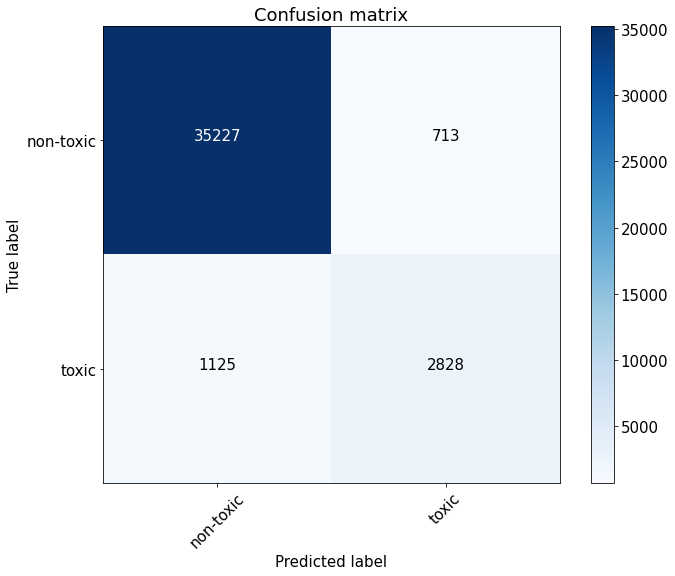

In [11]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])  # thresholds[ix] - best threshold
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-toxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### let's calculate TPR, FPR, TNR

In [12]:
TN, FP, FN, TP = confusion_matrix(y_test, y_score > thresholds[ix]).ravel()
TN, FP, FN, TP

(35227, 713, 1125, 2828)

In [13]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7154060207437389, 0.019838619922092376, 0.9801613800779077)

### let's visualize the threshold and classification results

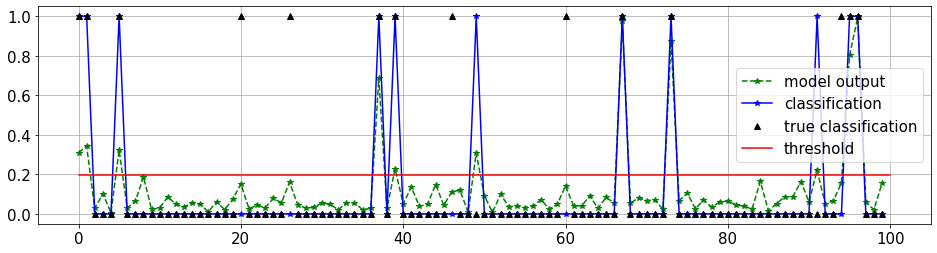

In [14]:
plt.figure(figsize=(16,4))

plt.plot(y_score[:100] , '--*g', label = 'model output')
plt.plot(y_score[:100] > thresholds[ix], '-*b', label = 'classification')
plt.plot(y_test.values[:100], '^k', label = 'true classification')
plt.grid('on')

plt.plot([0,100], [thresholds[ix], thresholds[ix]], 'r', label = 'threshold')

plt.legend()
plt.show()

## Business Metrics

### let's presume that a missed toxic comment costs us 10\\$ while a comment wrongly marked as toxic  - 1$

### let's find the best threshold to minimize our money loss

In [15]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])

pay_toxic = cnf_matrix[1,0]*10 + cnf_matrix[0,1]*1  # *10 - 10$ and *1 - 1$
print('threshold: ', thresholds[ix], 'money loss:', pay_toxic)

threshold:  0.19816534989457563 money loss: 11963


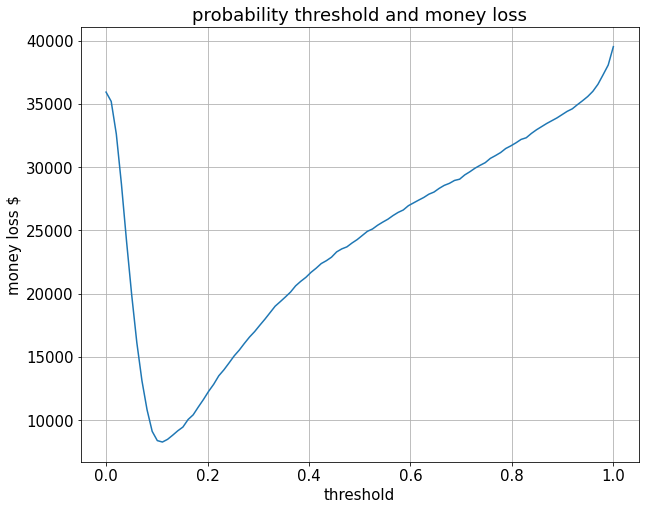

In [16]:
money_loss =[]
threshold_levels = np.linspace(0, 1, 100).tolist()
for threshold_level in threshold_levels:
    cnf_matrix = confusion_matrix(y_test, y_score > threshold_level)
    money_loss.append(cnf_matrix[1,0]*10 + cnf_matrix[0,1]*1)

plt.figure(figsize=(10, 8))
plt.plot(threshold_levels, money_loss)
plt.ylabel('money loss $')
plt.xlabel('threshold')
plt.title('probability threshold and money loss')
plt.grid()
plt.show()

In [17]:
money_loss_and_thresholds = pd.DataFrame({
    'threshold_levels': threshold_levels,
    'money_loss': money_loss  
})

money_loss_and_thresholds.sort_values(by='money_loss', ascending=True).head(3)

,threshold_levels,money_loss
11,0.111111,8276
10,0.101010,8389
12,0.121212,8488


In [18]:
threshold_business = money_loss_and_thresholds.sort_values(by='money_loss', ascending=True)['threshold_levels'].iloc[0]
threshold_business

0.11111111111111112

### so, despite our best DS threshold to maximise DS metric (F-score) was:

In [19]:
thresholds[ix]

0.19816534989457563

### the best threshold from the business point of view is:

In [20]:
threshold_business

0.11111111111111112

### but, from DS point of view, the new threshold decreases the DS metric (F-score) significantly:

In [21]:
f1_score(y_test.values, y_score > thresholds[ix])  # optimal DS threshold

0.7547371230317588

In [22]:
f1_score(y_test.values, y_score > threshold_business)  # optimal business threshold

0.6144326302945791

### let's draw a new confusion matrix with business-driven threshold

Confusion matrix, without normalization
[[31944  3996]
 [  428  3525]]


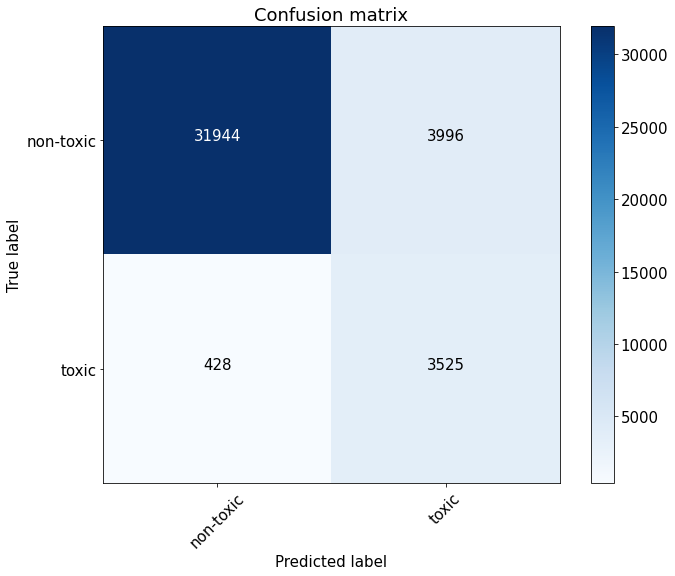

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > threshold_business)  # threshold_business - best threshold from business pov
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-toxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

as it's seen TP significantly increased

## the main idea is that the best DS metrics don't always collocate with the best business indicators